In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from signed_distance import *
from nlp_builder import NLPBuilder
from nlp_solver import SQPSolver
from functools import partial

In [2]:
# problem
num_steps = 10
center_obs = jnp.array([0, 0.1])
r_obs = 0.2

dim_robot = 2
r_robot = 0.1
safe_dist = 0.1

q_init = jnp.array([-1, -1])
q_goal = jnp.array([1, 1])
qu, ql = jnp.full(2, 1.1), jnp.full(2, -1.1)

In [3]:
#util functions
def to_mat(x):
    return x.reshape(-1, dim_robot)
def to_vec(mat):
    return mat.flatten()
def at_timestep(i, x):
    return to_mat(x)[i]
def to_vel(x):
    return (to_mat(x)[1:] - to_mat(x)[:-1]).flatten()

In [4]:
# functions
obs = Circle(center_obs, r_obs)
env = EnvSDF((obs,), safe_dist+r_robot)

def min_dist_cost(x):
    v = to_vel(x)
    return v @ v
state_init = partial(at_timestep, 0)
state_goal = partial(at_timestep,-1)
penetration = lambda x: env.penetrations(to_mat(x))

xl = jnp.tile(ql, num_steps)
xu = jnp.tile(qu, num_steps)
x0 = jnp.linspace(q_init, q_goal, num_steps).flatten()

### Build NLP problem

In [5]:
#build NLP problem 
dim = num_steps * dim_robot
nlp = NLPBuilder(dim=dim)
nlp.set_f(min_dist_cost)
nlp.add_eq_const(state_init, q_init, est_sparsity=True)
nlp.add_eq_const(state_goal, q_goal, est_sparsity=True)
nlp.add_eq_const(penetration, 0., est_sparsity=False)
nlp.set_state_bound(xl, xu)

In [6]:
solver = SQPSolver.from_builder(nlp,sparsity=True)
solver.prebuild(mode="BFGS")

In [7]:
x = jnp.zeros(solver.dim)
m = jnp.zeros(solver.const_dim)
sigma = 0.1

In [8]:
from cvxopt import matrix, sparse, solvers
state = solver.state_init_fn(x, m, sigma)
# solver.eval_fn(x, m, sigma, state)
#solver.armijo_cond_fn(x, x, 0., 0., 0.)
P, q, G, h, A, b = solver.convexify(state)

In [11]:
xsol = solver.solve(x0, tol=0.05, verbose=True, save_history=True)

0: grad:1.1415 | viol:0.2020 | alpha:0.2097
1: grad:0.5052 | viol:0.0333 | alpha:1.0000
2: grad:0.8755 | viol:0.0144 | alpha:0.4096
3: grad:0.7213 | viol:0.0092 | alpha:0.4096
4: grad:0.8216 | viol:0.0068 | alpha:0.5120
5: grad:0.9502 | viol:0.0103 | alpha:0.4096
6: grad:0.9162 | viol:0.0071 | alpha:0.5120
7: grad:0.4154 | viol:0.0027 | alpha:0.8000
8: grad:0.6327 | viol:0.0015 | alpha:0.5120
9: grad:0.9143 | viol:0.0010 | alpha:0.4096
10: grad:0.6630 | viol:0.0005 | alpha:0.6400
11: grad:1.2406 | viol:0.0004 | alpha:0.2097
SQP solved !


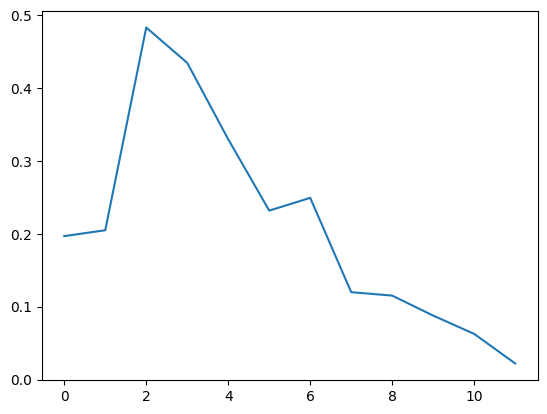

In [12]:
signal = [jnp.linalg.norm(h.direction) for h in solver.history]
plt.plot(signal)

In [13]:
xs = [s.x for s in solver.states]
len(xs)

12

In [14]:
i= 1

In [26]:
qs = to_mat(xs[i])
qs_prev = to_mat(xs[i-1])
fig, ax = plt.subplots()
robots = []
for q in qs_prev:
    circle = plt.Circle(q, r_robot, color='gray')
    robots.append(circle)
    ax.add_patch(circle)
for q in qs:
    circle = plt.Circle(q, r_robot, color='k')
    robots.append(circle)
    ax.add_patch(circle)

circle = plt.Circle(center_obs, r_obs, color='r')
ax.add_patch(circle)
ax = plt.scatter(*qs.T)
i += 1

IndexError: list index out of range

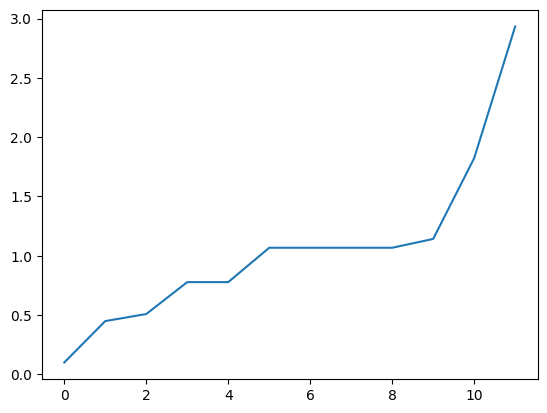

In [28]:
sigmas = jnp.array([h.sigma for h in solver.states])
plt.plot(sigmas)

In [26]:
sigmas

Array([1.0000000e-01, 4.4888955e-01, 5.0850010e-01, 7.7762508e-01,
       7.7762508e-01, 1.0670739e+00, 1.0670739e+00, 1.0677400e+00,
       1.0677400e+00, 1.1472164e+00, 1.8322680e+00, 2.9373739e+00,
       3.8571844e+00, 4.8486695e+00, 6.0244093e+00, 7.1699314e+00,
       1.3186608e+01, 2.2072178e+01, 2.2072178e+01, 2.2072178e+01,
       2.2072178e+01, 2.2072178e+01, 2.3042353e+01, 2.3042353e+01,
       2.7276217e+01, 4.7586693e+01, 2.4086908e+02, 2.4086908e+02,
       2.4086908e+02, 2.4086908e+02, 5.4509894e+02, 5.4509894e+02,
       5.4509894e+02, 5.4509894e+02, 6.0043262e+02, 6.0043262e+02,
       6.0043262e+02, 8.6465631e+02, 1.1285676e+03, 1.1809437e+03,
       2.4617295e+03], dtype=float32)